## Dog Breed Prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from keras.utils import load_img, img_to_array
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

#### Get Dataset form Kaggle

In [ ]:
# Download Dataset
!mkdir dataset
%cd dataset
!kaggle datasets download catherinehorng/dogbreedidfromcomp

In [3]:
# Unzip Dataset
!tar -xf dogbreedidfromcomp.zip

In [ ]:
# Delete Unwanted Files
!del dogbreedidfromcomp.zip
!del sample_submission.csv
%cd ..

#### Load data into pandas dataframe

In [5]:
labels = pd.read_csv('dataset/labels.csv')
print(labels.shape)
labels.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


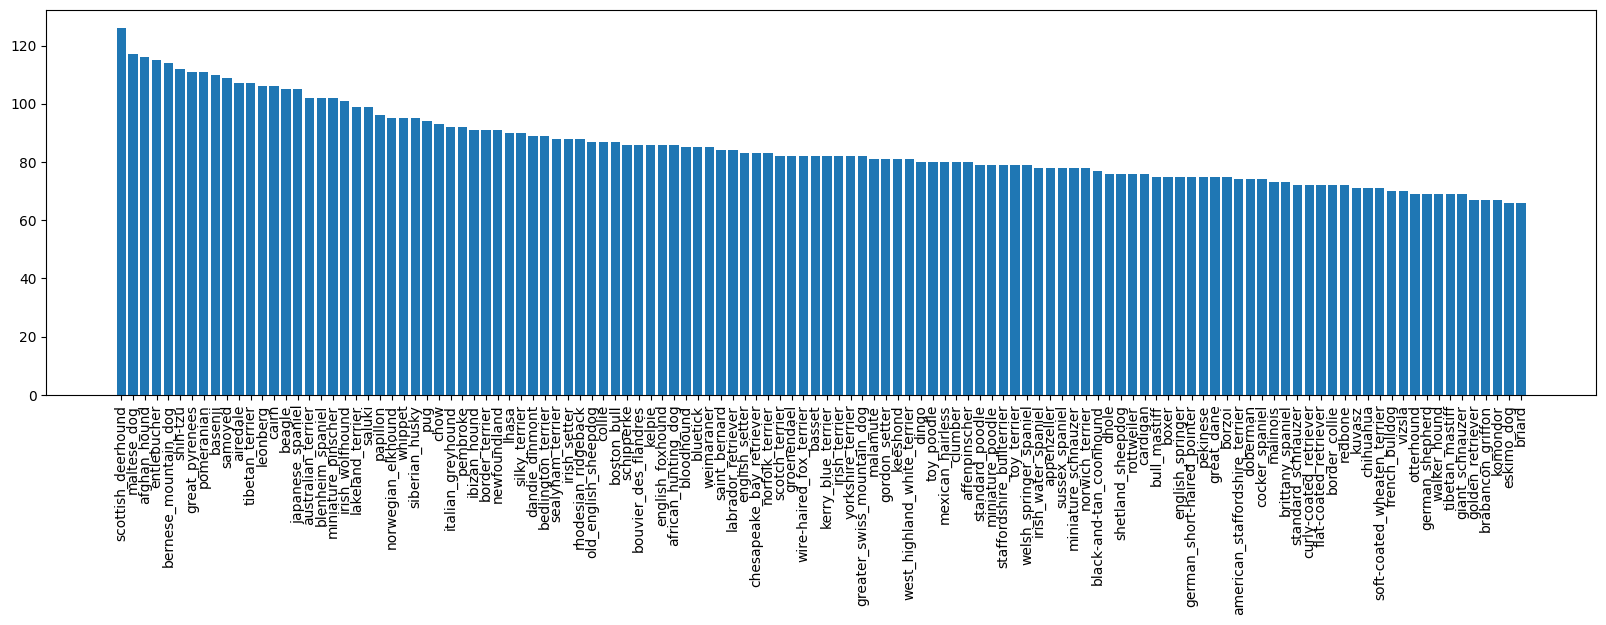

In [6]:
# Vizualize count of each breed
data = labels['breed'].value_counts()
fig, ax = plt.subplots(figsize = (20, 5))
ax.bar(data.index, data)
ax.tick_params(axis='x', labelrotation = 90)

#### Creating Data

In [7]:
# Selecting first 3 breeds (Limitation due to computation power)
CLASS_NAMES = ['scottish_deerhound','maltese_dog','afghan_hound']
labels = labels[(labels['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,146,0379145880ad3978f9b80f0dc2c03fba,afghan_hound


In [8]:
# Creating X_data
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')

for i in tqdm(range(len(labels))):
    img = load_img('dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = img_to_array(img)
    X_data[i] = img/255.0

100%|██████████| 359/359 [00:01<00:00, 318.26it/s]


In [9]:
# Creating Y_data
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

In [10]:
print(f'Train Images shape: {X_data.shape}, size: {X_data.size:,}')
print(f'One-hot encoded output shape: {Y_data.shape}, size: {Y_data.size:,}')

Train Images shape: (359, 224, 224, 3), size: 54,039,552
One-hot encoded output shape: (359, 3), size: 1,077


In [11]:
# Splitting the data set into training and testing data sets
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)

# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2)

#### Modelling

In [12]:
# Building the Model
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (4,4), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 32, kernel_size = (4,4), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 16, kernel_size = (4,4), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 8, kernel_size = (4,4), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001), metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 221, 221, 64)      3136      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 32)      32800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 16)        8208      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 16)       0

In [ ]:
# Training the model
epochs = 100
batch_size = 64

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val))

#### Model Evaluation

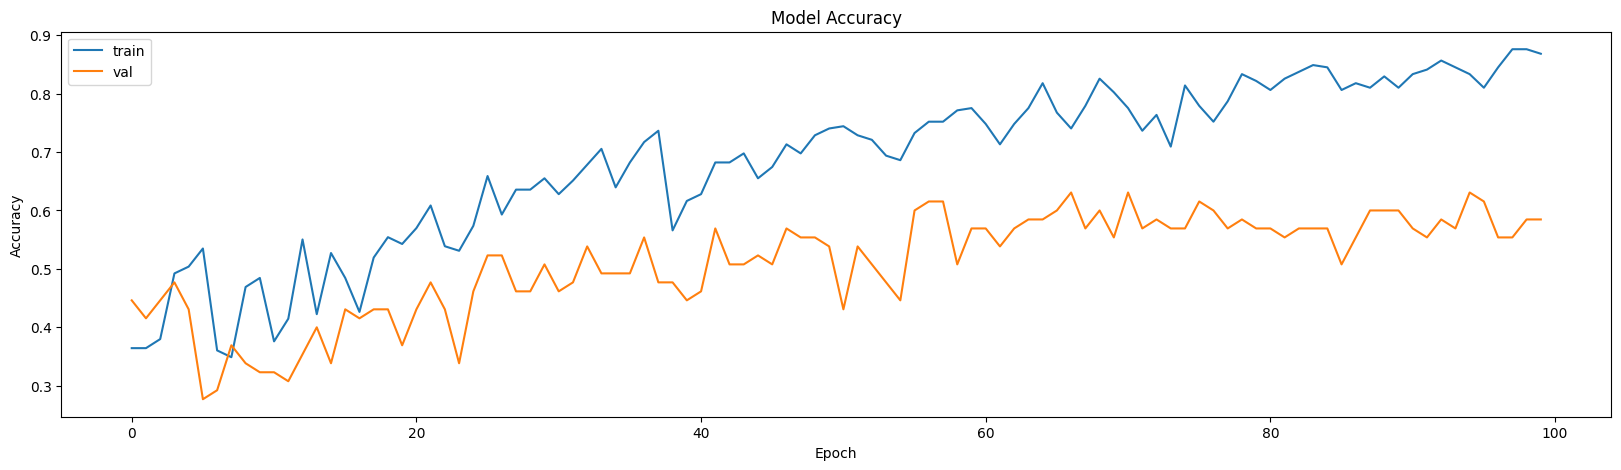

In [14]:
# Plot the training history
fig, ax = plt.subplots(figsize = (20, 5))
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.plot(history.history['accuracy'], label = 'train')
ax.plot(history.history['val_accuracy'], label = 'val')
_ = ax.legend()

In [15]:
# Model Accuracy on Test Data
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: %1.0f%%' % round((score[1]*100), 2))

2/2 [==============================] - 0s 5ms/step - loss: 2.2974 - accuracy: 0.7222
Accuracy over the test set: 72%


In [16]:
model.save('model.h5')